In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)

100%|██████████| 8.01G/8.01G [01:14<00:00, 115MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3


In [ ]:
import os
dataset_path = "/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3"
print(os.listdir(dataset_path))


['valid.csv', 'train_images', 'val_images', 'test.csv', 'train_1.csv', 'test_images']


In [ ]:
import pandas as pd

dataset_path = "/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3"

# Load training data CSV
train_df = pd.read_csv(f"{dataset_path}/train_1.csv")
print(train_df.head())  # Show first few rows


        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0


Fixing image directory structure...
✅ Images moved successfully!
✅ Sample image found: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/1ae8c165fd53.png


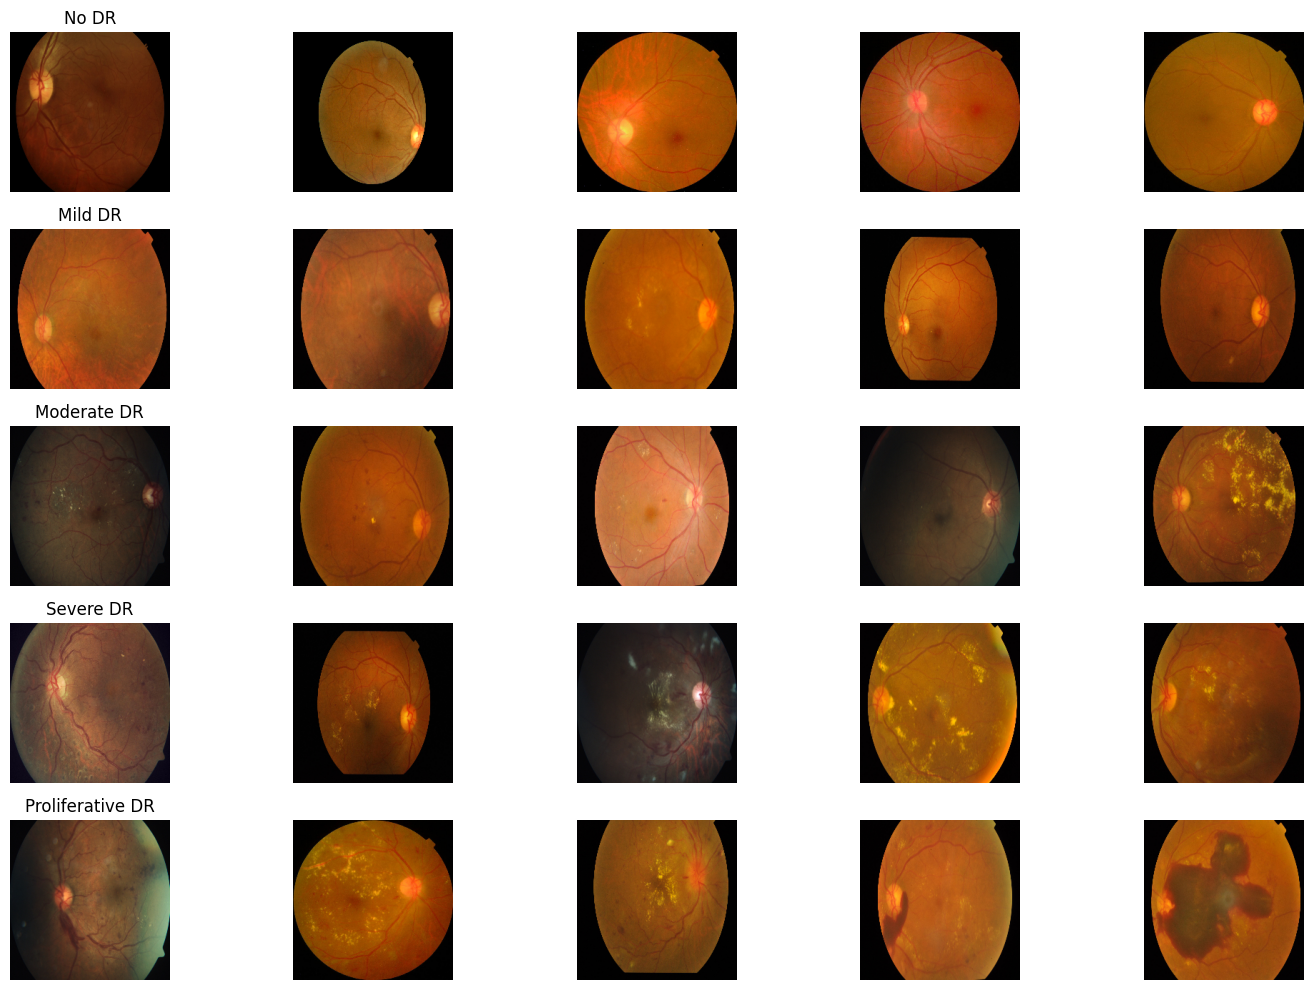

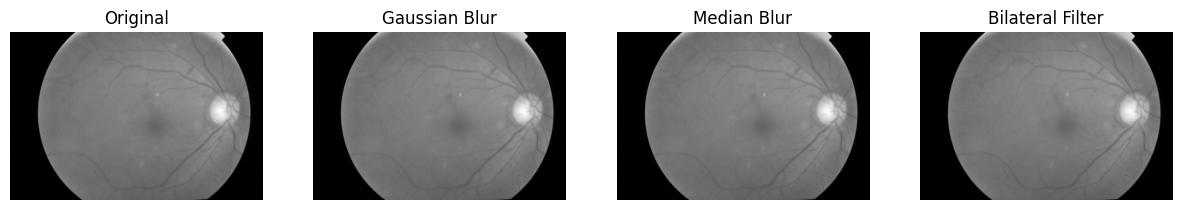

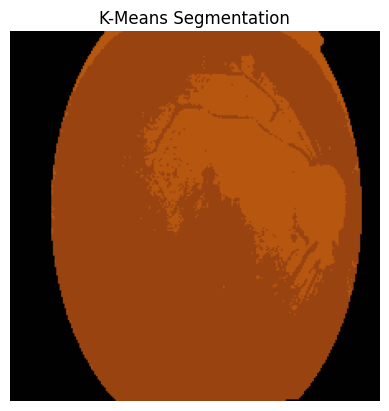

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 85.6MB/s]


Epoch 1, Loss: 0.812022836635942
Epoch 2, Loss: 0.6350441873073578
Epoch 3, Loss: 0.577826087889464
Epoch 4, Loss: 0.5205909740989623
Epoch 5, Loss: 0.4780171788904978
🎉 Training Complete!


In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from PIL import Image

# 1️⃣ Dataset Setup & Path Fixes
dataset_path = "/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3"
image_dir = os.path.join(dataset_path, "train_images")

# Fix nested folder issue
if "train_images" in os.listdir(image_dir):
    print("Fixing image directory structure...")
    !mv /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/train_images/* /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/
    print("✅ Images moved successfully!")

# Load CSV file
train_df = pd.read_csv(f"{dataset_path}/train_1.csv")

# Verify images exist
sample_image_id = train_df.iloc[0]['id_code']
img_path = os.path.join(image_dir, f"{sample_image_id}.png")

if os.path.exists(img_path):
    print(f"✅ Sample image found: {img_path}")
else:
    print("❌ Error: Sample image not found!")

# 2️⃣ Display Images by Severity Level
severity_labels = {0: "No DR", 1: "Mild DR", 2: "Moderate DR", 3: "Severe DR", 4: "Proliferative DR"}

def show_images_by_class(df, num_images=5):
    fig, axes = plt.subplots(5, num_images, figsize=(15, 10))
    for i in range(5):  # 5 classes (0-4)
        class_samples = df[df['diagnosis'] == i].sample(num_images, random_state=42)
        for j, (_, row) in enumerate(class_samples.iterrows()):
            img_path = os.path.join(image_dir, f"{row['id_code']}.png")
            if not os.path.exists(img_path):
                continue  # Skip missing images

            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))

            axes[i, j].imshow(image)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(severity_labels[i], fontsize=12)

    plt.tight_layout()
    plt.show()

show_images_by_class(train_df)

# 3️⃣ Apply Noise Reduction
def apply_filters(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    median_blur = cv2.medianBlur(image, 5)
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original")
    axes[1].imshow(gaussian_blur, cmap="gray")
    axes[1].set_title("Gaussian Blur")
    axes[2].imshow(median_blur, cmap="gray")
    axes[2].set_title("Median Blur")
    axes[3].imshow(bilateral, cmap="gray")
    axes[3].set_title("Bilateral Filter")

    for ax in axes:
        ax.axis("off")

    plt.show()

apply_filters(img_path)

# 4️⃣ Retinal Disease Segmentation (K-Means Clustering)
def kmeans_segmentation(image_path, k=3):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    _, labels, centers = cv2.kmeans(pixel_values, k, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    plt.imshow(segmented_image)
    plt.axis("off")
    plt.title("K-Means Segmentation")
    plt.show()

kmeans_segmentation(img_path)

# 5️⃣ Train CNN for DR Classification (ResNet50)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class RetinalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.data.iloc[idx, 0]}.png")
        image = Image.open(img_name).convert("RGB")
        label = int(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = RetinalDataset(f"{dataset_path}/train_1.csv", image_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

model = resnet50(pretrained=True)
model.fc = nn.Linear(2048, 5)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

print("🎉 Training Complete!")


mv: cannot stat '/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/train_images/*': No such file or directory


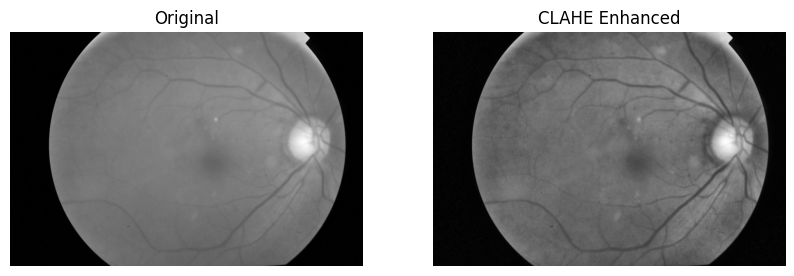

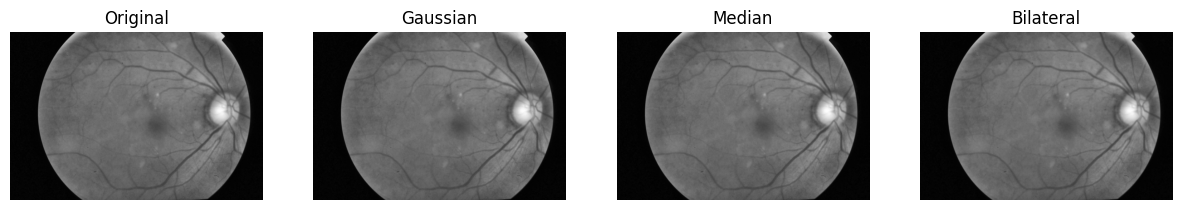

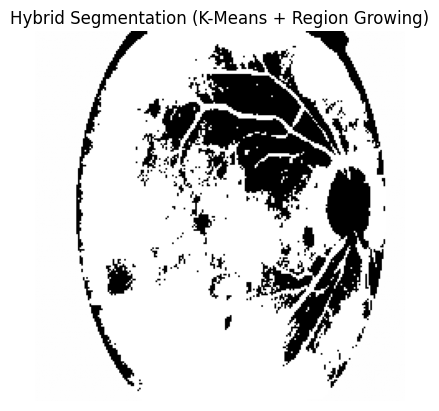

TypeError: unsupported operand type(s) for //: 'NoneType' and 'int'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ✅ 1️⃣ Setup Dataset & Fix Image Paths
dataset_path = "/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3"
image_dir = os.path.join(dataset_path, "train_images")

# Fix any nested folder issue
if "train_images" in os.listdir(image_dir):
    !mv {image_dir}/train_images/* {image_dir}/

train_df = pd.read_csv(f"{dataset_path}/train_1.csv")
sample_image_id = train_df.iloc[0]['id_code']
img_path = os.path.join(image_dir, f"{sample_image_id}.png")

# ✅ 2️⃣ Contrast Enhancement using CLAHE
def apply_clahe(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap="gray"), axes[0].set_title("Original")
    axes[1].imshow(enhanced_image, cmap="gray"), axes[1].set_title("CLAHE Enhanced")
    for ax in axes: ax.axis("off")
    plt.show()

    return enhanced_image

enhanced_image = apply_clahe(img_path)

# ✅ 3️⃣ Apply Noise Reduction Filters (Gaussian, Median, Bilateral)
def apply_filters(image):
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    median_blur = cv2.medianBlur(image, 5)
    bilateral = cv2.bilateralFilter(image, 9, 75, 75)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, title, img in zip(axes, ["Original", "Gaussian", "Median", "Bilateral"], [image, gaussian_blur, median_blur, bilateral]):
        ax.imshow(img, cmap="gray"), ax.set_title(title), ax.axis("off")
    plt.show()

    return bilateral  # Returning the best noise-filtered image

filtered_image = apply_filters(enhanced_image)

# ✅ 4️⃣ Hybrid Segmentation (K-Means + Region Growing) - FIXED floodFill issue
def hybrid_segmentation(image):
    image = cv2.resize(image, (224, 224))

    # K-Means Clustering
    pixel_values = image.reshape((-1, 1)).astype(np.float32)
    _, labels, centers = cv2.kmeans(pixel_values, 3, None,
                                    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2),
                                    10, cv2.KMEANS_RANDOM_CENTERS)

    segmented_image = labels.reshape(image.shape).astype(np.uint8) * 255  # Scale values for visualization

    # ✅ Fix: Create a mask that is 2 pixels larger in both dimensions
    mask = np.zeros((image.shape[0] + 2, image.shape[1] + 2), np.uint8)

    # Apply Region Growing (Flood Fill)
    seed_point = (112, 112)  # Center of image
    cv2.floodFill(segmented_image, mask, seed_point, 255)

    plt.imshow(segmented_image, cmap="gray")
    plt.axis("off")
    plt.title("Hybrid Segmentation (K-Means + Region Growing)")
    plt.show()

    return segmented_image

segmented_image = hybrid_segmentation(filtered_image)

# ✅ 5️⃣ IoU & Dice Score Evaluation
def compute_iou_dice(segmented_img, ground_truth_img):
    """
    Compute IoU (Intersection over Union) and Dice Coefficient.
    segmented_img: Binary mask of segmented image
    ground_truth_img: Binary mask of ground truth image
    """
    # Convert images to binary (0 and 1)
    segmented_bin = cv2.threshold(segmented_img, 127, 255, cv2.THRESH_BINARY)[1] // 255
    ground_truth_bin = cv2.threshold(ground_truth_img, 127, 255, cv2.THRESH_BINARY)[1] // 255

    # Compute Intersection and Union
    intersection = np.logical_and(segmented_bin, ground_truth_bin).sum()
    union = np.logical_or(segmented_bin, ground_truth_bin).sum()

    # Compute IoU
    iou = intersection / union if union != 0 else 0

    # Compute Dice Coefficient
    dice = (2 * intersection) / (segmented_bin.sum() + ground_truth_bin.sum()) if (segmented_bin.sum() + ground_truth_bin.sum()) != 0 else 0

    return iou, dice

# Load Ground Truth Mask (Replace with actual mask path)
ground_truth_path = "ground_truth_mask.png"  # Replace with the correct mask file
ground_truth_img = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)

# Compute IoU & Dice Score
iou_score, dice_score = compute_iou_dice(segmented_image, ground_truth_img)

print(f"✅ IoU Score: {iou_score:.4f}")
print(f"✅ Dice Coefficient: {dice_score:.4f}")


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/drive-digital-retinal-images-for-vessel-extraction")

print("Path to dataset files:", path)

100%|██████████| 28.0M/28.0M [00:00<00:00, 87.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1


In [ ]:
import os

drive_dataset_path = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1"

# List all files and folders
print("Available files and folders:", os.listdir(drive_dataset_path))


Available files and folders: ['DRIVE']


In [ ]:
import os

drive_main_folder = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE"

# List all files and subfolders
print("Subfolders inside DRIVE:", os.listdir(drive_main_folder))


Subfolders inside DRIVE: ['test', 'training']


In [ ]:
import os

drive_main_folder = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE"

# List contents of 'training' folder
training_folder = os.path.join(drive_main_folder, "training")
print("Files in 'training' folder:", os.listdir(training_folder))

# List contents of 'test' folder
test_folder = os.path.join(drive_main_folder, "test")
print("Files in 'test' folder:", os.listdir(test_folder))


Files in 'training' folder: ['mask', 'images', '1st_manual']
Files in 'test' folder: ['mask', 'images']


In [ ]:
import os

train_mask_folder = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/training/mask"
test_mask_folder = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/test/mask"

# List sample mask files
print("Training Mask Files:", os.listdir(train_mask_folder)[:5])
print("Test Mask Files:", os.listdir(test_mask_folder)[:5])


Training Mask Files: ['29_training_mask.gif', '24_training_mask.gif', '25_training_mask.gif', '33_training_mask.gif', '35_training_mask.gif']
Test Mask Files: ['20_test_mask.gif', '18_test_mask.gif', '16_test_mask.gif', '06_test_mask.gif', '14_test_mask.gif']


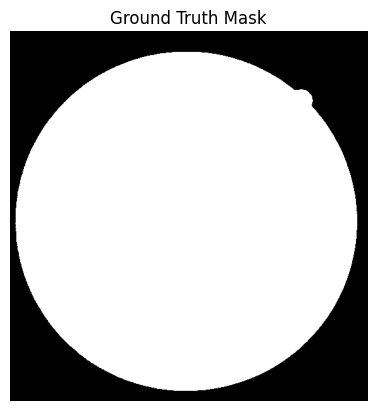

In [ ]:
from PIL import Image  # PIL supports .gif format
import cv2
import numpy as np

def load_ground_truth_mask(mask_path):
    """
    Loads a ground truth mask from a .gif file and converts it to grayscale.
    """
    # Open GIF and convert to grayscale
    mask = Image.open(mask_path).convert("L")  # "L" mode = grayscale
    mask = np.array(mask)  # Convert to NumPy array
    return mask

# Example usage:
ground_truth_path = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/training/mask/29_training_mask.gif"
ground_truth_img = load_ground_truth_mask(ground_truth_path)

# Show the loaded mask
import matplotlib.pyplot as plt
plt.imshow(ground_truth_img, cmap="gray")
plt.axis("off")
plt.title("Ground Truth Mask")
plt.show()


TypeError: Image data of dtype object cannot be converted to float

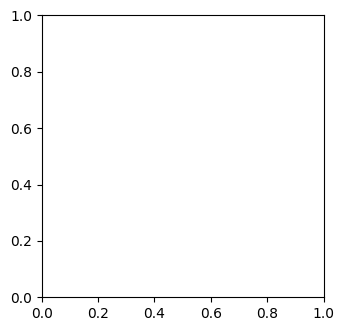

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# ✅ 1️⃣ Load Retinal Image & Ground Truth Mask
image_path = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/training/images/29_training.tif"
mask_path = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/training/mask/29_training_mask.gif"

# Load images
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(image, cmap='gray'); plt.title("Original Image")
plt.subplot(1,2,2); plt.imshow(ground_truth, cmap='gray'); plt.title("Ground Truth Mask")
plt.show()

# ✅ 2️⃣ Noise Reduction (CLAHE, Gaussian, Median, Bilateral)
def apply_noise_reduction(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(image)

    img_gaussian = cv2.GaussianBlur(img_clahe, (5,5), 0)
    img_median = cv2.medianBlur(img_clahe, 5)
    img_bilateral = cv2.bilateralFilter(img_clahe, 9, 75, 75)

    return img_clahe, img_gaussian, img_median, img_bilateral

clahe_img, gaussian_img, median_img, bilateral_img = apply_noise_reduction(image)

plt.figure(figsize=(10,5))
plt.subplot(2,2,1); plt.imshow(clahe_img, cmap='gray'); plt.title("CLAHE")
plt.subplot(2,2,2); plt.imshow(gaussian_img, cmap='gray'); plt.title("Gaussian Blur")
plt.subplot(2,2,3); plt.imshow(median_img, cmap='gray'); plt.title("Median Blur")
plt.subplot(2,2,4); plt.imshow(bilateral_img, cmap='gray'); plt.title("Bilateral Filter")
plt.show()

# ✅ 3️⃣ Hybrid Segmentation (K-Means + Region Growing)
def hybrid_segmentation(image):
    # Step 1: K-Means Clustering
    reshaped_img = image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans.fit(reshaped_img)
    segmented_image = kmeans.labels_.reshape(image.shape).astype(np.uint8) * 255

    # Step 2: Region Growing
    seed_point = (112, 112)
    mask = np.zeros((image.shape[0] + 2, image.shape[1] + 2), np.uint8)
    cv2.floodFill(segmented_image, mask, seed_point, 255)

    return segmented_image

segmented_image = hybrid_segmentation(median_img)

plt.figure(figsize=(5,5))
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image (Hybrid)")
plt.show()

# ✅ 4️⃣ Compute IoU & Dice Score
def compute_iou_dice(segmented_img, ground_truth_img):
    # Convert images to binary
    segmented_bin = cv2.threshold(segmented_img, 127, 255, cv2.THRESH_BINARY)[1] // 255
    ground_truth_bin = cv2.threshold(ground_truth_img, 127, 255, cv2.THRESH_BINARY)[1] // 255

    # Compute Intersection and Union
    intersection = np.logical_and(segmented_bin, ground_truth_bin).sum()
    union = np.logical_or(segmented_bin, ground_truth_bin).sum()

    iou_score = intersection / union
    dice_score = (2 * intersection) / (segmented_bin.sum() + ground_truth_bin.sum())

    return iou_score, dice_score

iou_score, dice_score = compute_iou_dice(segmented_image, ground_truth)

print(f"✅ IoU Score: {iou_score:.4f}")
print(f"✅ Dice Score: {dice_score:.4f}")


In [ ]:
import os

print("Image Path Exists:", os.path.exists(image_path))
print("Mask Path Exists:", os.path.exists(mask_path))


Image Path Exists: False
Mask Path Exists: False


In [ ]:
# Define dataset root path
dataset_root = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/"

# Select a sample file from training set
image_filename = "29_training.tif"   # Change this based on available files
mask_filename = "29_training_mask.gif"

# Construct full paths
image_path = os.path.join(dataset_root, "training/images", image_filename)
mask_path = os.path.join(dataset_root, "training/mask", mask_filename)

print("Corrected Image Path:", image_path)
print("Corrected Mask Path:", mask_path)
print("Image Path Exists:", os.path.exists(image_path))
print("Mask Path Exists:", os.path.exists(mask_path))


Corrected Image Path: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/training/images/29_training.tif
Corrected Mask Path: /root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/training/mask/29_training_mask.gif
Image Path Exists: True
Mask Path Exists: True


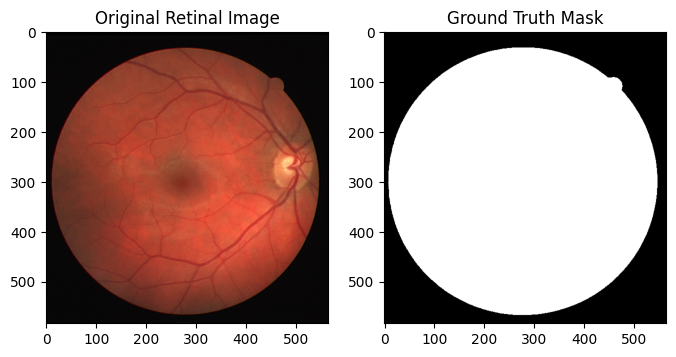

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # For handling .gif masks

# Load retinal image (.tif)
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

# Load ground truth mask (.gif)
mask = Image.open(mask_path)  # PIL handles .gif better
mask = np.array(mask)  # Convert to NumPy array

# Plot the images
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Retinal Image")

# Ground Truth Mask
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Ground Truth Mask")

plt.show()


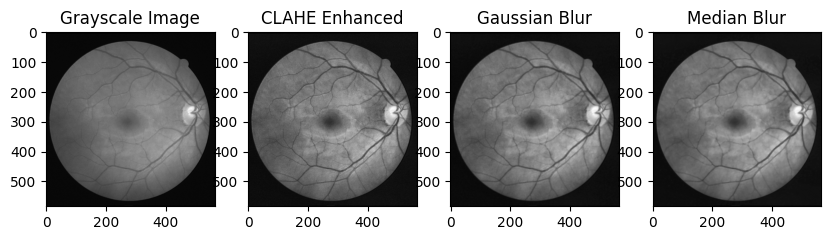

In [ ]:
# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
enhanced_image = clahe.apply(gray_image)

# Apply noise reduction filters
gaussian_blur = cv2.GaussianBlur(enhanced_image, (5, 5), 0)
median_blur = cv2.medianBlur(enhanced_image, 5)
bilateral_blur = cv2.bilateralFilter(enhanced_image, 9, 75, 75)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 4, 1)
plt.imshow(gray_image, cmap="gray")
plt.title("Grayscale Image")

plt.subplot(1, 4, 2)
plt.imshow(enhanced_image, cmap="gray")
plt.title("CLAHE Enhanced")

plt.subplot(1, 4, 3)
plt.imshow(gaussian_blur, cmap="gray")
plt.title("Gaussian Blur")

plt.subplot(1, 4, 4)
plt.imshow(median_blur, cmap="gray")
plt.title("Median Blur")

plt.show()


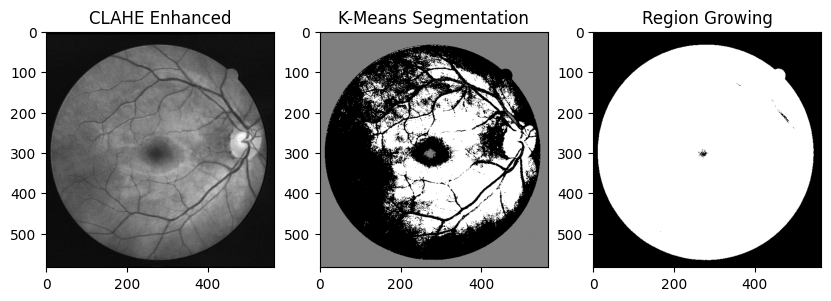

In [ ]:
from sklearn.cluster import KMeans

# Reshape the image for K-Means
reshaped_image = enhanced_image.reshape(-1, 1)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(reshaped_image)

# Reshape back to original image shape
kmeans_segmented = kmeans_labels.reshape(enhanced_image.shape)

# Apply region growing using thresholding
_, region_grown = cv2.threshold(enhanced_image, 50, 255, cv2.THRESH_BINARY)

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(enhanced_image, cmap="gray")
plt.title("CLAHE Enhanced")

plt.subplot(1, 3, 2)
plt.imshow(kmeans_segmented, cmap="gray")
plt.title("K-Means Segmentation")

plt.subplot(1, 3, 3)
plt.imshow(region_grown, cmap="gray")
plt.title("Region Growing")

plt.show()


In [ ]:
from sklearn.metrics import jaccard_score
import numpy as np

# Flatten the images for metric calculation
ground_truth_flat = ground_truth.flatten() // 255  # Normalize to 0 and 1
segmented_flat = region_grown.flatten() // 255  # Normalize to 0 and 1

# Compute IoU
iou_score = jaccard_score(ground_truth_flat, segmented_flat)

# Compute Dice Score
dice_score = 2 * np.sum(ground_truth_flat * segmented_flat) / (np.sum(ground_truth_flat) + np.sum(segmented_flat))

print(f"IoU Score: {iou_score:.4f}")
print(f"Dice Score: {dice_score:.4f}")


AttributeError: 'NoneType' object has no attribute 'flatten'

In [ ]:
print(type(ground_truth), ground_truth.shape if ground_truth is not None else "None")
print(type(region_grown), region_grown.shape if region_grown is not None else "None")


<class 'NoneType'> None
<class 'numpy.ndarray'> (584, 565)


In [ ]:
print("Unique values in ground truth mask:", np.unique(ground_truth))
print("Unique values in segmented mask:", np.unique(region_grown))


Unique values in ground truth mask: [None]
Unique values in segmented mask: [  0 255]


In [ ]:
import cv2

# Load the ground truth mask properly
mask_path = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/training/mask/29_training_mask.gif"
ground_truth = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Check if it's loaded correctly
if ground_truth is None:
    print("Error: Ground truth mask not loaded correctly!")
else:
    print("Ground truth mask loaded successfully!")


Error: Ground truth mask not loaded correctly!


In [ ]:
import os

mask_path = "/root/.cache/kagglehub/datasets/andrewmvd/drive-digital-retinal-images-for-vessel-extraction/versions/1/DRIVE/training/mask/29_training_mask.gif"

# Check if the file exists
if os.path.exists(mask_path):
    print("✅ Ground truth mask file exists.")
else:
    print("❌ Error: Ground truth mask file does NOT exist!")


✅ Ground truth mask file exists.


In [ ]:
from PIL import Image
import numpy as np

# Load the mask using PIL
mask_image = Image.open(mask_path).convert("L")  # Convert to grayscale

# Convert to NumPy array
ground_truth = np.array(mask_image)

print("✅ Ground truth mask loaded successfully!")
print("Shape:", ground_truth.shape)
print("Unique values:", np.unique(ground_truth))


✅ Ground truth mask loaded successfully!
Shape: (584, 565)
Unique values: [  0 255]


In [ ]:
import cv2

# Apply threshold to convert grayscale to binary
_, ground_truth = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)

print("✅ Binary mask created!")
print("Unique values in binary mask:", np.unique(ground_truth))


✅ Binary mask created!
Unique values in binary mask: [  0 255]


In [ ]:
ground_truth_flat = ground_truth.flatten() // 255  # Normalize to 0 and 1


In [ ]:
# Flatten the images for metric calculation
ground_truth_flat = ground_truth.flatten() // 255  # Normalize to 0 and 1
segmented_flat = region_grown.flatten() // 255  # Normalize to 0 and 1

print("Flattened ground truth shape:", ground_truth_flat.shape)
print("Flattened segmented shape:", segmented_flat.shape)


Flattened ground truth shape: (329960,)
Flattened segmented shape: (329960,)
